# Text Statistics

In [1]:
%matplotlib inline

In [2]:
import os
import pandas as pd
import re
from datetime import datetime

The ends of our log files contain statistics on how many files were processed.

In [3]:
def read_counts(path):
    """Read the number of processed documents from the tail of a log file."""
    # file names are in YYMM format
    filename = os.path.splitext(os.path.basename(path))[0]
    date = datetime.strptime(filename+'01', '%y%m%d').date()
    
    counter = 0
    output = []
    with open(path, 'r') as infil:
        for line in reversed(infil.readlines()):
            rx = re.search(r'^# ([^.]+)\.+ :([ 0-9]+)', line)
            if rx is None:
                continue

            bucket = rx.group(1).strip()
            docs = int(rx.group(2))
            output += [{'date': date, 'bucket': bucket, 'count': docs}]

            counter += 1
            if counter  == 5:
                break
    
    return output

In [4]:
logfiles = os.path.join(os.getcwd(), '../../data/arxiv/logs')

In [5]:
data = []
for log in os.listdir(logfiles):
    data += read_counts(os.path.join(logfiles, log))
data = pd.DataFrame(data)

In [6]:
data = data.pivot_table(columns='bucket', values='count', index='date')
data.head()

bucket      Input  No source  No text  Not-gzipped  Processed
date                                                         
1991-07-01      2          0        0            0          2
1991-08-01     28          6       16            0          6
1991-09-01     58          6       32            0         20
1991-10-01     76         11       33            0         32
1991-11-01     64         14       24            0         26

Sanity check: are any input counts illogical?

In [7]:
assert data.loc[data['Input'] < data['Processed'], :].shape[0] == 0

In [8]:
# Aggregate by year
data['year'] = data.index.map(lambda i: i.year)
data = data.groupby('year').agg('sum')

# Fix hierarchical nonsense
data.columns = data.columns.values

In [9]:
data.head()

Input  No source  No text  Not-gzipped  Processed
year                                                   
1991    306         50      145            0        111
1992   3261        721     1139            0       1401
1993   6741       1453     1826           11       3451
1994  10088       2275     2327            0       5486
1995  13002       2794     2512            4       7692

In [10]:
# Reorder columns
data = data.iloc[:, [4, 3, 1, 2, 0]]

### Visualizations

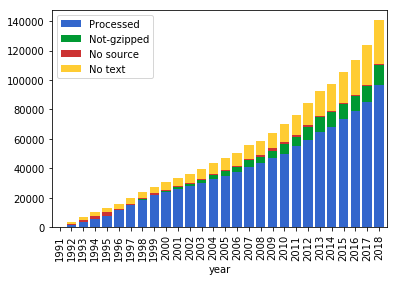

In [11]:
ax = (data
      .drop('Input', axis=1)
      .plot
      .bar(
          stacked=True,
          figsize=(6, 4),
          color=['#3366cc', '#009933', '#cc3333', '#ffcc33'],
          width=0.8
      ))

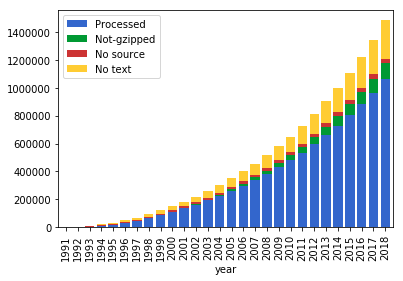

In [12]:
ax = (data
      .drop('Input', axis=1)
      .sort_index()
      .apply(lambda col: pd.Series.cumsum(col))
      .plot.bar(
          stacked=True,
          figsize=(6, 4),
          color=['#3366cc', '#009933', '#cc3333', '#ffcc33'],
          width=0.8
      ))

Some definitions:

 - *Processed* documents produce text output
 - *Not-gzipped* documents cannot be processed at all (e.g., PDFs)
 - *No source* documents do not have obvious LaTeX source files
 - *No text* documents likely produce errors in *pandoc* and do not produce text

#### Number of Text Documents:

In [13]:
data['Processed'].sum()

1062145

In [14]:
data['Total Processed'] = data.loc[:, 'Processed'].cumsum()
data

Processed  Not-gzipped  No source  No text   Input  Total Processed
year                                                                     
1991        111            0         50      145     306              111
1992       1401            0        721     1139    3261             1512
1993       3451           11       1453     1826    6741             4963
1994       5486            0       2275     2327   10088            10449
1995       7692            4       2794     2512   13002            18141
1996      11410            5       1181     3270   15866            29551
1997      15019           24        809     3772   19624            44570
1998      18853          144        903     4267   24167            63423
1999      21801          303        889     4702   27695            85224
2000      23994          600        863     5130   30587           109218
2001      25975         1121        720     5381   33197           135193
2002      28143         1347        691     5921   36102           163336
2003      30279         1845        598     6687   39409           193615
2004      32996         2518        683     7511   43708           226611
2005      34838         3075        922     7992   46827           261449
2006      37349         3425       1084     8366   50224           298798
2007      41126         4282       1094     9136   55638           339924
2008      43323         4597       1295     9700   58915           383247
2009      47171         4964       1390    10521   64046           430418
2010      50098         6183       1760    12084   70125           480516
2011      55053         6263       1557    13701   76574           535569
2012      59362         8817       1453    14971   84603           594931
2013      64440        10145        972    17084   92641           659371
2014      68375         9886        817    18439   97517           727746
2015      73812         9651        861    20956  105280           801558
2016      78761        10293        857    23469  113380           880319
2017      84995        11177        712    26639  123523           965314
2018      96831        13451        553    29781  140616          1062145

#### Fraction of Unprocessable Documents Per Year

In [15]:
data.drop('Input', axis=1).apply(lambda col: round(col/data['Input'], 3))

Processed  Not-gzipped  No source  No text  Total Processed
year                                                             
1991      0.363        0.000      0.163    0.474            0.363
1992      0.430        0.000      0.221    0.349            0.464
1993      0.512        0.002      0.216    0.271            0.736
1994      0.544        0.000      0.226    0.231            1.036
1995      0.592        0.000      0.215    0.193            1.395
1996      0.719        0.000      0.074    0.206            1.863
1997      0.765        0.001      0.041    0.192            2.271
1998      0.780        0.006      0.037    0.177            2.624
1999      0.787        0.011      0.032    0.170            3.077
2000      0.784        0.020      0.028    0.168            3.571
2001      0.782        0.034      0.022    0.162            4.072
2002      0.780        0.037      0.019    0.164            4.524
2003      0.768        0.047      0.015    0.170            4.913
2004      0.755        0.058      0.016    0.172            5.185
2005      0.744        0.066      0.020    0.171            5.583
2006      0.744        0.068      0.022    0.167            5.949
2007      0.739        0.077      0.020    0.164            6.110
2008      0.735        0.078      0.022    0.165            6.505
2009      0.737        0.078      0.022    0.164            6.720
2010      0.714        0.088      0.025    0.172            6.852
2011      0.719        0.082      0.020    0.179            6.994
2012      0.702        0.104      0.017    0.177            7.032
2013      0.696        0.110      0.010    0.184            7.117
2014      0.701        0.101      0.008    0.189            7.463
2015      0.701        0.092      0.008    0.199            7.614
2016      0.695        0.091      0.008    0.207            7.764
2017      0.688        0.090      0.006    0.216            7.815
2018      0.689        0.096      0.004    0.212            7.554